<a href="https://colab.research.google.com/github/spetznick/applied-gpu-programming/blob/colab-s/assignment-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Assignment 2
Explain how the program is compiled and run.
For a vector length of N:

1. How many floating operations are being performed in your vector add kernel?
2. How many global memory reads are being performed by your kernel?

For a vector length of 512:

1. Explain how many CUDA threads and thread blocks you used.
2. Profile your program with Nvidia Nsight. What Achieved Occupancy did you get? You might find https://docs.nvidia.com/nsight-compute/NsightComputeCli/index.html#nvprof-metric-comparison
Links to an external site. useful.

Now increase the vector length to 262140:

1. Did your program still work? If not, what changes did you make?
2. Explain how many CUDA threads and thread blocks you used.
Profile your program with Nvidia Nsight. What Achieved Occupancy do you get now?

Further increase the vector length (try 6-10 different vector length), plot a stacked bar chart showing the breakdown of time including (1) data copy from host to device (2) the CUDA kernel (3) data copy from device to host. For this, you will need to add simple CPU timers to your code regions.





In [ ]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Wed Nov 13 13:38:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              13W /  7


## First exercise of the second assignment


In [ ]:
%%writefile hw2_ex1.cu
#include <stdio.h>
#include <sys/time.h>

#define DataType double

__global__ void vecAdd(DataType *in1, DataType *in2, DataType *out, int len) {
  int myID = blockIdx.x * blockDim.x + threadIdx.x;
  if (myID < len) {
    out[myID] = in1[myID] + in2[myID];
  }
}

// Function to calculate mean and standard deviation of an array of floats
void calculateMeanAndStdDev(float *times, int numRuns, float *mean, float *stdDev) {
  float sum = 0.0;
  for (int i = 0; i < numRuns; i++) {
    sum += times[i];
  }
  *mean = sum / numRuns;

  float variance = 0.0;
  for (int i = 0; i < numRuns; i++) {
    variance += (times[i] - *mean) * (times[i] - *mean);
  }
  *stdDev = sqrt(variance / numRuns);
}

int main(int argc, char **argv) {
  if (argc < 4) {
    printf("Please provide vector length, thread number, and number of runs as command-line arguments.\n");
    return 1;
  }

  int inputLength = strtol(argv[1], NULL, 10);
  int numThreadsPerBlock = strtol(argv[2], NULL, 10);
  int numRuns = strtol(argv[3], NULL, 10);

  int size = inputLength * sizeof(DataType);
  DataType *hostInput1 = (DataType *)malloc(size);
  DataType *hostInput2 = (DataType *)malloc(size);
  DataType *hostOutput = (DataType *)malloc(size);
  DataType *resultRef = (DataType *)malloc(size);

  // Initialize host inputs with random values
  srand(time(NULL));
  for (int i = 0; i < inputLength; ++i) {
    hostInput1[i] = (DataType)rand() / RAND_MAX;
    hostInput2[i] = (DataType)rand() / RAND_MAX;
  }

  DataType *deviceInput1, *deviceInput2, *deviceOutput;
  cudaMalloc(&deviceInput1, size);
  cudaMalloc(&deviceInput2, size);
  cudaMalloc(&deviceOutput, size);

  dim3 blockDim(numThreadsPerBlock);
  dim3 gridDim((inputLength + blockDim.x - 1) / blockDim.x);
  printf("The input length is %d, (numBlocks, numThreadsPerBlock) = (%d, %d).\n", inputLength, gridDim.x, blockDim.x);

  // CUDA events for timing
  cudaEvent_t start, stop;
  cudaEventCreate(&start);
  cudaEventCreate(&stop);

  float *kernelTimes = (float *)malloc(numRuns * sizeof(float));
  float *copyToDeviceTimes = (float *)malloc(numRuns * sizeof(float));
  float *copyToHostTimes = (float *)malloc(numRuns * sizeof(float));

  for (int run = 0; run < numRuns; run++) {
    // Time data copy to device
    cudaEventRecord(start);
    cudaMemcpy(deviceInput1, hostInput1, size, cudaMemcpyHostToDevice);
    cudaMemcpy(deviceInput2, hostInput2, size, cudaMemcpyHostToDevice);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&copyToDeviceTimes[run], start, stop);

    // Time kernel execution
    cudaEventRecord(start);
    vecAdd<<<gridDim, blockDim>>>(deviceInput1, deviceInput2, deviceOutput, inputLength);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&kernelTimes[run], start, stop);

    // Time data copy back to host
    cudaEventRecord(start);
    cudaMemcpy(hostOutput, deviceOutput, size, cudaMemcpyDeviceToHost);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&copyToHostTimes[run], start, stop);
  }

  float meanKernelTime, stdDevKernelTime;
  float meanCopyToDeviceTime, stdDevCopyToDeviceTime;
  float meanCopyToHostTime, stdDevCopyToHostTime;

  calculateMeanAndStdDev(kernelTimes, numRuns, &meanKernelTime, &stdDevKernelTime);
  calculateMeanAndStdDev(copyToDeviceTimes, numRuns, &meanCopyToDeviceTime, &stdDevCopyToDeviceTime);
  calculateMeanAndStdDev(copyToHostTimes, numRuns, &meanCopyToHostTime, &stdDevCopyToHostTime);

  printf("Input length %d, (numBlocks, numThreadsPerBlock) = (%d, %d).\n", inputLength, gridDim.x, blockDim.x);
  printf("Average kernel execution time of %d runs: %.4f +- %.4f ms\n", numRuns, meanKernelTime, stdDevKernelTime);
  printf("Average time for data copy to device:     %.4f +- %.4f ms\n", meanCopyToDeviceTime, stdDevCopyToDeviceTime);
  printf("Average time for data copy to host:       %.4f +- %.4f ms\n", meanCopyToHostTime, stdDevCopyToHostTime);

  // Error checking and final result comparison
  for (int i = 0; i < inputLength; ++i) {
    resultRef[i] = hostInput1[i] + hostInput2[i];
  }
  for (int i = 0; i < inputLength; ++i) {
    if (abs(resultRef[i] - hostOutput[i]) > 1e-5) {
      printf("Addition wrong at %i: (cpu, gpu) = (%.3f, %.3f)\n", i, resultRef[i], hostOutput[i]);
      break;
    }
  }

  cudaFree(deviceInput1);
  cudaFree(deviceInput2);
  cudaFree(deviceOutput);

  free(hostInput1);
  free(hostInput2);
  free(hostOutput);
  free(resultRef);
  free(kernelTimes);
  free(copyToDeviceTimes);
  free(copyToHostTimes);

  cudaEventDestroy(start);
  cudaEventDestroy(stop);

  return 0;
}


Overwriting hw2_ex1.cu


## We compile the saved cuda code using nvcc compiler

In [ ]:
!nvcc hw2_ex1.cu -o hw2_ex1
!ls


hw2_ex1  hw2_ex1.cu  sample_data  vectorAdd.cu


## Finally, we execute the binary of the compiled code

In [ ]:
!./hw2_ex1 10 256
!./hw2_ex1 10 512
!./hw2_ex1 512 256 10
!./hw2_ex1 512 512 10
!./hw2_ex1 512 1024 10
!./hw2_ex1 10000 256
!./hw2_ex1 10000 512
!./hw2_ex1 10000 1024
!./hw2_ex1 100000 256 10
!./hw2_ex1 100000 512 10
!./hw2_ex1 100000 1024 10

The input length is 512, (numBlocks, numThreadsPerBlock) = (2, 256).
Input length 512, (numBlocks, numThreadsPerBlock) = (2, 256).
Average kernel execution time of 10 runs: 0.0263 +- 0.0593 ms
Average time for data copy to device:     0.0205 +- 0.0048 ms
Average time for data copy to host:       0.0159 +- 0.0035 ms
The input length is 512, (numBlocks, numThreadsPerBlock) = (1, 512).
Input length 512, (numBlocks, numThreadsPerBlock) = (1, 512).
Average kernel execution time of 10 runs: 0.0266 +- 0.0589 ms
Average time for data copy to device:     0.0203 +- 0.0037 ms
Average time for data copy to host:       0.0178 +- 0.0028 ms
The input length is 512, (numBlocks, numThreadsPerBlock) = (1, 1024).
Input length 512, (numBlocks, numThreadsPerBlock) = (1, 1024).
Average kernel execution time of 10 runs: 0.0257 +- 0.0564 ms
Average time for data copy to device:     0.0196 +- 0.0026 ms
Average time for data copy to host:       0.0141 +- 0.0042 ms
The input length is 100000, (numBlocks, numThre

## Vector length 512

In [ ]:
!ncu --section "Occupancy" ./hw2_ex1 512 256 1

==PROF== Connected to process 29549 (/content/hw2_ex1)
The input length is 512, (numBlocks, numThreadsPerBlock) = (2, 256).
==PROF== Profiling "vecAdd" - 0: 0%....50%....100% - 1 pass
==PROF== Profiling "vecAdd" - 1: 0%....50%....100% - 1 pass
==PROF== Profiling "vecAdd" - 2: 0%....50%....100% - 1 pass
==PROF== Profiling "vecAdd" - 3: 0%....50%....100% - 1 pass
==PROF== Profiling "vecAdd" - 4: 0%....50%....100% - 1 pass
==PROF== Profiling "vecAdd" - 5: 0%....50%....100% - 1 pass
==PROF== Profiling "vecAdd" - 6: 0%....50%....100% - 1 pass
==PROF== Profiling "vecAdd" - 7: 0%....50%....100% - 1 pass
==PROF== Profiling "vecAdd" - 8: 0%....50%....100% - 1 pass
==PROF== Profiling "vecAdd" - 9: 0%....50%....100% - 1 pass
Input length 512, (numBlocks, numThreadsPerBlock) = (2, 256).
Average kernel execution time of 10 runs: 34.8490 +- 68.9776 ms
Average time for data copy to device:     0.0283 +- 0.0080 ms
Average time for data copy to host:       0.0331 +- 0.0096 ms
==PROF== Disconnected from

## Vector length 262140

In [ ]:
!ncu --section "Occupancy" ./hw2_ex1 262140 256 1

==PROF== Connected to process 29683 (/content/hw2_ex1)
The input length is 262140, (numBlocks, numThreadsPerBlock) = (1024, 256).
==PROF== Profiling "vecAdd" - 0: 0%....50%....100% - 1 pass
Input length 262140, (numBlocks, numThreadsPerBlock) = (1024, 256).
Average kernel execution time of 1 runs: 240.0350 +- 0.0000 ms
Average time for data copy to device:     1.2110 +- 0.0000 ms
Average time for data copy to host:       1.8493 +- 0.0000 ms
==PROF== Disconnected from process 29683
[29683] hw2_ex1@127.0.0.1
  vecAdd(double *, double *, double *, int) (1024, 1, 1)x(256, 1, 1), Context 1, Stream 7, Device 0, CC 7.5
    Section: Occupancy
    ------------------------------- ----------- ------------
    Metric Name                     Metric Unit Metric Value
    ------------------------------- ----------- ------------
    Block Limit SM                        block           16
    Block Limit Registers                 block           16
    Block Limit Shared Mem                block     

## Experiment with other sizes

In [ ]:
!./hw2_ex1 100000 256 10
!./hw2_ex1 1000000 256 10
!./hw2_ex1 10000000 256 10
!./hw2_ex1 100000000 256 10
!./hw2_ex1 500000000 256 10
!./hw2_ex1 1000000000 256 10
!./hw2_ex1 10000000000 256 10

The input length is 100000, (numBlocks, numThreadsPerBlock) = (391, 256).
Input length 100000, (numBlocks, numThreadsPerBlock) = (391, 256).
Average kernel execution time of 10 runs: 0.0338 +- 0.0579 ms
Average time for data copy to device:     0.4606 +- 0.0284 ms
Average time for data copy to host:       0.3056 +- 0.1264 ms
The input length is 1000000, (numBlocks, numThreadsPerBlock) = (3907, 256).
Input length 1000000, (numBlocks, numThreadsPerBlock) = (3907, 256).
Average kernel execution time of 10 runs: 0.1145 +- 0.0502 ms
Average time for data copy to device:     3.2693 +- 0.1583 ms
Average time for data copy to host:       2.1796 +- 1.2151 ms
The input length is 10000000, (numBlocks, numThreadsPerBlock) = (39063, 256).
Input length 10000000, (numBlocks, numThreadsPerBlock) = (39063, 256).
Average kernel execution time of 10 runs: 0.9398 +- 0.0547 ms
Average time for data copy to device:     34.1295 +- 0.7819 ms
Average time for data copy to host:       21.0678 +- 11.7128 ms
The 

   Input Length  Kernel Execution Time (ms)  Copy to Device Time (ms)  \
0        100000                      0.0338                    0.4606   
1       1000000                      0.1145                    3.2693   
2      10000000                      0.9398                   34.1295   
3     100000000                      9.1669                  349.7391   

   Copy to Host Time (ms)  
0                  0.3056  
1                  2.1796  
2                 21.0678  
3                213.4426  


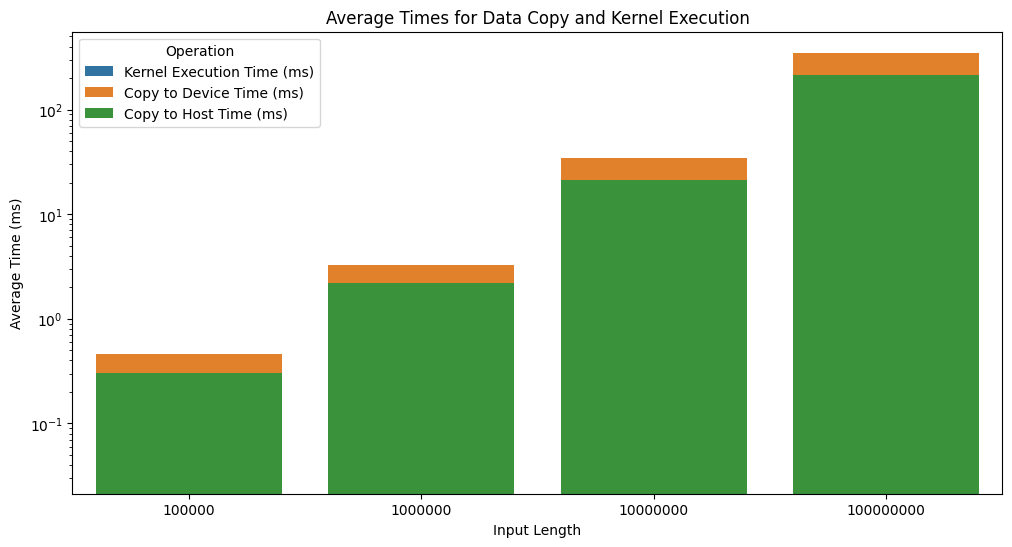

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import pandas as pd

def parse_results(results_str):
    """
    Parses the results of multiple test runs and returns a DataFrame.

    Args:
    - results_str (str): A string containing the test run output.

    Returns:
    - df (pd.DataFrame): A DataFrame containing the parsed results.
    """

    # Regex pattern to match each block of results for a single input length
    pattern = r"The input length is (\d+), \(numBlocks, numThreadsPerBlock\) = \(\d+, \d+\).\s*Input length \d+, \(numBlocks, numThreadsPerBlock\) = \(\d+, \d+\).\s*Average kernel execution time of \d+ runs: ([\d.]+) \+- [\d.]+ ms\s*Average time for data copy to device: +([\d.]+) \+- [\d.]+ ms\s*Average time for data copy to host: +([\d.]+) \+- [\d.]+ ms"

    # Use regex to find all matches in the string
    matches = re.findall(pattern, results_str)

    # Create a list to store the parsed data
    data = []

    # Parse each match and store as a dictionary
    for match in matches:
        input_length = int(match[0])
        kernel_time = float(match[1])
        copy_to_device_time = float(match[2])
        copy_to_host_time = float(match[3])

        # Append the parsed data to the list
        data.append({
            "Input Length": input_length,
            "Kernel Execution Time (ms)": kernel_time,
            "Copy to Device Time (ms)": copy_to_device_time,
            "Copy to Host Time (ms)": copy_to_host_time
        })

    # Convert the data list to a DataFrame
    df = pd.DataFrame(data)

    return df

# Example usage with the input printout string
results_str = """
The input length is 100000, (numBlocks, numThreadsPerBlock) = (391, 256).
Input length 100000, (numBlocks, numThreadsPerBlock) = (391, 256).
Average kernel execution time of 10 runs: 0.0338 +- 0.0579 ms
Average time for data copy to device:     0.4606 +- 0.0284 ms
Average time for data copy to host:       0.3056 +- 0.1264 ms
The input length is 1000000, (numBlocks, numThreadsPerBlock) = (3907, 256).
Input length 1000000, (numBlocks, numThreadsPerBlock) = (3907, 256).
Average kernel execution time of 10 runs: 0.1145 +- 0.0502 ms
Average time for data copy to device:     3.2693 +- 0.1583 ms
Average time for data copy to host:       2.1796 +- 1.2151 ms
The input length is 10000000, (numBlocks, numThreadsPerBlock) = (39063, 256).
Input length 10000000, (numBlocks, numThreadsPerBlock) = (39063, 256).
Average kernel execution time of 10 runs: 0.9398 +- 0.0547 ms
Average time for data copy to device:     34.1295 +- 0.7819 ms
Average time for data copy to host:       21.0678 +- 11.7128 ms
The input length is 100000000, (numBlocks, numThreadsPerBlock) = (390625, 256).
Input length 100000000, (numBlocks, numThreadsPerBlock) = (390625, 256).
Average kernel execution time of 10 runs: 9.1669 +- 0.0574 ms
Average time for data copy to device:     349.7391 +- 15.5713 ms
Average time for data copy to host:       213.4426 +- 116.5841 ms
"""

# Parse the results
df = parse_results(results_str)

# Print the resulting DataFrame
print(df)

# # Data preparation
# data = {
#     "Input Length": [100000, 1000000, 5000000, 10000000, 50000000, 100000000],
#     "Kernel Execution Time (ms)": [0.0332, 0.1134, 0.4788, 0.9397, 4.5879, 9.1720],
#     "Copy to Device Time (ms)": [0.4653, 3.2890, 16.9438, 34.2606, 171.6111, 335.4579],
#     "Copy to Host Time (ms)": [0.3076, 2.1924, 10.8117, 21.0833, 104.4536, 207.1870]
# }

# # Convert the data into a pandas DataFrame
# df = pd.DataFrame(data)

# Reshape the DataFrame for a stacked bar plot
df_melted = df.melt(id_vars="Input Length",
                    value_vars=["Kernel Execution Time (ms)", "Copy to Device Time (ms)", "Copy to Host Time (ms)"],
                    var_name="Operation",
                    value_name="Time (ms)")

# Plotting the stacked bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="Input Length", y="Time (ms)", hue="Operation", dodge=False)

# Adding plot details
plt.title("Average Times for Data Copy and Kernel Execution")
plt.xlabel("Input Length")
plt.ylabel("Average Time (ms)")
plt.yscale("log")  # Log scale can help better visualize the differences across large ranges
plt.legend(title="Operation", loc="upper left")

plt.show()


In [ ]:
%%writefile nvidia_matrixmultiply.cu
// Matrices are stored in row-major order:
// M(row, col) = *(M.elements + row * M.stride + col)
typedef struct {
    int width;
    int height;
    int stride;
    float* elements;
} Matrix;
// Get a matrix element
__device__ float GetElement(const Matrix A, int row, int col)
{
    return A.elements[row * A.stride + col];
}
// Set a matrix element
__device__ void SetElement(Matrix A, int row, int col,
                           float value)
{
    A.elements[row * A.stride + col] = value;
}
// Get the BLOCK_SIZExBLOCK_SIZE sub-matrix Asub of A that is
// located col sub-matrices to the right and row sub-matrices down
// from the upper-left corner of A
 __device__ Matrix GetSubMatrix(Matrix A, int row, int col)
{
    Matrix Asub;
    Asub.width    = BLOCK_SIZE;
    Asub.height   = BLOCK_SIZE;
    Asub.stride   = A.stride;
    Asub.elements = &A.elements[A.stride * BLOCK_SIZE * row
                                         + BLOCK_SIZE * col];
    return Asub;
}
// Thread block size
#define BLOCK_SIZE 16
// Forward declaration of the matrix multiplication kernel
__global__ void MatMulKernel(const Matrix, const Matrix, Matrix);
// Matrix multiplication - Host code
// Matrix dimensions are assumed to be multiples of BLOCK_SIZE
void MatMul(const Matrix A, const Matrix B, Matrix C)
{
    // Load A and B to device memory
    Matrix d_A;
    d_A.width = d_A.stride = A.width; d_A.height = A.height;
    size_t size = A.width * A.height * sizeof(float);
    cudaMalloc(&d_A.elements, size);
    cudaMemcpy(d_A.elements, A.elements, size,
               cudaMemcpyHostToDevice);
    Matrix d_B;
    d_B.width = d_B.stride = B.width; d_B.height = B.height;
    size = B.width * B.height * sizeof(float);
    cudaMalloc(&d_B.elements, size);
    cudaMemcpy(d_B.elements, B.elements, size,
    cudaMemcpyHostToDevice);
    // Allocate C in device memory
    Matrix d_C;
    d_C.width = d_C.stride = C.width; d_C.height = C.height;
    size = C.width * C.height * sizeof(float);
    cudaMalloc(&d_C.elements, size);
    // Invoke kernel
    dim3 dimBlock(BLOCK_SIZE, BLOCK_SIZE);
    dim3 dimGrid(B.width / dimBlock.x, A.height / dimBlock.y);
    MatMulKernel<<<dimGrid, dimBlock>>>(d_A, d_B, d_C);
    // Read C from device memory
    cudaMemcpy(C.elements, d_C.elements, size,
               cudaMemcpyDeviceToHost);
    // Free device memory
    cudaFree(d_A.elements);
    cudaFree(d_B.elements);
    cudaFree(d_C.elements);
}
// Matrix multiplication kernel called by MatMul()
 __global__ void MatMulKernel(Matrix A, Matrix B, Matrix C)
{
    // Block row and column
    int blockRow = blockIdx.y;
    int blockCol = blockIdx.x;
    // Each thread block computes one sub-matrix Csub of C
    Matrix Csub = GetSubMatrix(C, blockRow, blockCol);
    // Each thread computes one element of Csub
    // by accumulating results into Cvalue
    float Cvalue = 0;
    // Thread row and column within Csub
    int row = threadIdx.y;
    int col = threadIdx.x;
    // Loop over all the sub-matrices of A and B that are
    // required to compute Csub
    // Multiply each pair of sub-matrices together
    // and accumulate the results
    for (int m = 0; m < (A.width / BLOCK_SIZE); ++m) {
        // Get sub-matrix Asub of A
        Matrix Asub = GetSubMatrix(A, blockRow, m);
        // Get sub-matrix Bsub of B
        Matrix Bsub = GetSubMatrix(B, m, blockCol);
        // Shared memory used to store Asub and Bsub respectively
        __shared__ float As[BLOCK_SIZE][BLOCK_SIZE];
        __shared__ float Bs[BLOCK_SIZE][BLOCK_SIZE];
        // Load Asub and Bsub from device memory to shared memory
        // Each thread loads one element of each sub-matrix
        As[row][col] = GetElement(Asub, row, col);
        Bs[row][col] = GetElement(Bsub, row, col);
        // Synchronize to make sure the sub-matrices are loaded
        // before starting the computation
        __syncthreads();
        // Multiply Asub and Bsub together
        for (int e = 0; e < BLOCK_SIZE; ++e)
            Cvalue += As[row][e] * Bs[e][col];
        // Synchronize to make sure that the preceding
        // computation is done before loading two new
        // sub-matrices of A and B in the next iteration
        __syncthreads();
    }
    // Write Csub to device memory
    // Each thread writes one element
    SetElement(Csub, row, col, Cvalue);
}

In [ ]:
%%writefile hw2_ex2.cu
#include <stdio.h>
#include <sys/time.h>

#define DataType double

// Compute C = A * B each thread computes a single entry
__global__ void gemm(DataType *A, DataType *B, DataType *C, int numARows,
                      int numAColumns, int numBRows, int numBColumns){
  //@@ Insert code to implement matrix multiplication here
  DataType cValue = 0;
  int row = blockIdx.y * blockDim.y + threadIdx.y;
  int col = blockIdx.x * blockDim.x + threadIdx.x;
  if (row < numARows && col < numBColumns) {
    for (int i = 0; i < numAColumns; ++i) {
      cValue += A[row * numAColumns + i] * B[i * numBColumns + col];
    }
  }
  C[row * numBColumns + col] = cValue;
}

// Function to calculate mean and standard deviation of an array of floats
void calculateMeanAndStdDev(float *times, int numRuns, float *mean, float *stdDev) {
  float sum = 0.0;
  for (int i = 0; i < numRuns; i++) {
    sum += times[i];
  }
  *mean = sum / numRuns;

  float variance = 0.0;
  for (int i = 0; i < numRuns; i++) {
    variance += (times[i] - *mean) * (times[i] - *mean);
  }
  *stdDev = sqrt(variance / numRuns);
}

int main(int argc, char **argv) {

  DataType *hostA; // The A matrix
  DataType *hostB; // The B matrix
  DataType *hostC; // The output C matrix
  DataType *resultRef; // The reference result
  DataType *deviceA;
  DataType *deviceB;
  DataType *deviceC;
  int numARows;    // number of rows in the matrix A
  int numAColumns; // number of columns in the matrix A
  int numBRows;    // number of rows in the matrix B
  int numBColumns; // number of columns in the matrix B
  int numCRows;
  int numCColumns;

  //@@ Insert code below to read in numARows, numAColumns, numBColumns from args
  if (argc < 6) {
    printf("Please provide number of matrix rows and columns of A and B, respectively, and the number of runs as command-line arguments.\n");
    return 1;
  }

  int numARows = strtol(argv[1], NULL, 15);
  int numAColumns = strtol(argv[2], NULL, 15);
  int numBRows = strtol(argv[3], NULL, 15);
  int numBColumns = strtol(argv[4], NULL, 15);
  int numRuns = strtol(argv[5], NULL, 10);
  numCRows = numARows;
  numCColumns = numBColumns;

  //! Input dim is given as expected by user but internally, B matrix is stored in column-major
  printf("Input matrix dim (%d x %d) (%d x %d) (%d x %d)\n", numARows, numAColumns, numBRows, numBColumns, numCRows, numCColumns);


  //@@ Insert code below to allocate Host memory for input and output
  int size = numAColumns * numARows * sizeof(DataType);
  DataType *hostA = (DataType *)malloc(size);
  DataType *hostB = (DataType *)malloc(size);
  DataType *hostC = (DataType *)malloc(size);
  DataType *resultRef = (DataType *)malloc(size);


  //@@ Insert code below to initialize hostA and hostB to random numbers, and create reference result in CPU
  srand(time(NULL));
  for (int i = 0; i < inputLength; ++i) {
    hostA[i] = (DataType)rand() / RAND_MAX;
    hostB[i] = (DataType)rand() / RAND_MAX;
  }

  //@@ Insert code below to allocate GPU memory here
  cudaMalloc(&deviceA, size);
  cudaMalloc(&deviceB, size);
  cudaMalloc(&deviceC, size);

  //@@ Initialize the grid and block dimensions here
  // 16x16 should be possible for most architectures
  dim3 blockDim(16, 16);
  dim3 gridDim(16, 16);
  dim3 dimGrid(B.width / dimBlock.x, A.height / dimBlock.y);

  // CUDA events for timing
  cudaEvent_t start, stop;
  cudaEventCreate(&start);
  cudaEventCreate(&stop);

  float *kernelTimes = (float *)malloc(numRuns * sizeof(float));
  float *copyToDeviceTimes = (float *)malloc(numRuns * sizeof(float));
  float *copyToHostTimes = (float *)malloc(numRuns * sizeof(float));

  for (int run = 0; run < numRuns; run++) {
    //@@ Insert code to below to Copy memory to the GPU here
    // Time data copy to device
    cudaEventRecord(start);
    cudaMemcpy(deviceA, hostA, size, cudaMemcpyHostToDevice);
    cudaMemcpy(deviceB, hostB, size, cudaMemcpyHostToDevice);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&copyToDeviceTimes[run], start, stop);

    //@@ Launch the GPU Kernel here
    cudaEventRecord(start);
    gemm<<<gridDim, blockDim>>>(deviceA, deviceB, deviceC, numARows,
                      numAColumns, numBRows, numBColumns);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&kernelTimes[run], start, stop);

    //@@ Copy the GPU memory back to the CPU here
    cudaEventRecord(start);
    cudaMemcpy(hostOutput, deviceOutput, size, cudaMemcpyDeviceToHost);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&copyToHostTimes[run], start, stop);
  }

  float meanKernelTime, stdDevKernelTime;
  float meanCopyToDeviceTime, stdDevCopyToDeviceTime;
  float meanCopyToHostTime, stdDevCopyToHostTime;

  calculateMeanAndStdDev(kernelTimes, numRuns, &meanKernelTime, &stdDevKernelTime);
  calculateMeanAndStdDev(copyToDeviceTimes, numRuns, &meanCopyToDeviceTime, &stdDevCopyToDeviceTime);
  calculateMeanAndStdDev(copyToHostTimes, numRuns, &meanCopyToHostTime, &stdDevCopyToHostTime);

  printf("Average kernel execution time of %d runs: %.4f +- %.4f ms\n", numRuns, meanKernelTime, stdDevKernelTime);
  printf("Average time for data copy to device:     %.4f +- %.4f ms\n", meanCopyToDeviceTime, stdDevCopyToDeviceTime);
  printf("Average time for data copy to host:       %.4f +- %.4f ms\n", meanCopyToHostTime, stdDevCopyToHostTime);

  //@@ Insert code below to compare the output with the reference
  for (int row = 0; row < numARows; ++row) {
    // B stored in column major!
    for (int col = 0; col < numBColumns; ++col) {
      // assume row major order for resultRef
      resultRef[row * numBColumns + col] = 0.;
      for (int k = 0, k < numBRows, ++k) {
        resultRef[row * numBColumns + col] += hostA[row * numAColumns + k] * hostB[col * numBColumns + k];
      }
    }
  }
  DataType eps = 1e-5;
  for (int i = 0, i < size, ++i) {
    if (fabs(hostC[i] - resultRef[i]) < eps) printf("Result wrong at index %d", i);
  }


  //@@ Free the GPU memory here
  cudaFree(deviceA);
  cudaFree(deviceB);
  cudaFree(deviceC);

  //@@ Free the CPU memory here
  free(hostA);
  free(hostB);
  free(hostC);
  free(resultRef);
  free(kernelTimes);
  free(copyToDeviceTimes);
  free(copyToHostTimes);

  // Free timer memory
  cudaEventDestroy(start);
  cudaEventDestroy(stop);

  return 0;
}



1. Name three applications domains of matrix multiplication.
2. How many floating operations are being performed in your matrix multiply kernel?
3. How many global memory reads are being performed by your kernel?  
4. For a matrix A of (64x128) and B of (128x64):
  - Explain how many CUDA threads and thread blocks you used.
  - Profile your program with Nvidia Nsight. What Achieved Occupancy did you get?
5. For a matrix A of (1024x1023) and B of (1023x8193):
  - Did your program still work? If not, what changes did you make?
  - Explain how many CUDA threads and thread blocks you used.
  - Profile your program with Nvidia Nsight. What Achieved Occupancy do you get now?
6. Further increase the size of matrix A and B, plot a stacked bar chart showing the breakdown of time including (1) data copy from host to device (2) the CUDA kernel (3) data copy from device to host. For this, you will need to add simple CPU timers to your code regions. Explain what you observe.
7. Now, change DataType from double to float, re-plot the a stacked bar chart showing the time breakdown. Explain what you observe.
